In [1]:
# --------------------------------------------------------
# Copyright (C) 2019 NVIDIA Corporation. All rights reserved.
# NVIDIA Source Code License (1-Way Commercial)
# Code written by Seonwook Park, Shalini De Mello, Yufeng Zheng.
# --------------------------------------------------------
import numpy as np
from collections import OrderedDict
import gc
import json
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import logging
from dataset import HDFDataset
from utils import save_images, worker_init_fn, send_data_dict_to_gpu, recover_images, def_test_list, RunningStatistics,\
    adjust_learning_rate, script_init_common, get_example_images, save_model, load_model
from core import DefaultConfig
from models import STED
os.environ["CUDA_VISIBLE_DEVICES"]="0"
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)
from models.gazeheadResnet import GazeHeadResNet

# Set Configurations
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model STED
network = STED().to(device)
load_model(network, os.path.join("/home/vuthede/STED-gaze/ST-ED", "checkpoints", str(206865) + '.pt'))
network.eval()
print(f'Loaded model STED success!!!!!')

# Load model eval gaze resnet
gazehead_net = GazeHeadResNet()
ckpt = "/home/vuthede/STED-gaze/baseline_estimator_resnet/at_step_0140000.pth.tar"
weights = torch.load(ckpt)
if next(iter(weights.keys())).startswith('module.'):
    weights = dict([(k[7:], v) for k, v in weights.items()])
gazehead_net.load_state_dict(weights)
gazehead_net.to(device)
gazehead_net.eval()
print(f'Load model GazeHead eval success')

2023-01-18 07:54:26,069 Loading /home/vuthede/STED-gaze/config/ST-ED.json


/home/vuthede/STED-gaze/config/ST-ED.json
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/vuthede/anaconda3/envs/dms/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
Loaded model STED success!!!!!
Load model GazeHead eval success


In [2]:
dataset = HDFDataset(hdf_file_path="/home/vuthede/faze_preprocess/outputs_sted/MPIIGaze.h5",
                             prefixes=None,
                             is_bgr=False,
                             get_2nd_sample=True,
                             pick_at_least_per_person=2)
print(f'Len dataset : {len(dataset)}')

Len dataset : 34790


dict_keys(['key', 'image_a', 'gaze_a', 'head_a', 'image_b', 'gaze_b', 'head_b'])
0.0 1.0


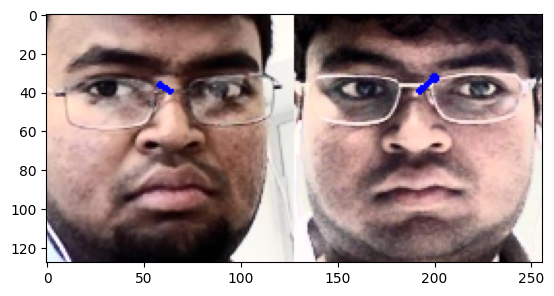

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

def draw_gaze(image_in, eye_pos, pitchyaw, length=15.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    
    # Vinai
    dx = -length * np.sin(pitchyaw[1])* np.cos(pitchyaw[0])
    dy = length * np.sin(pitchyaw[0])
    
    # They
    # dx = -length * np.sin(pitchyaw[1])
    # dy = -length * np.sin(pitchyaw[0])
    
    cv2.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)

    return image_out

index = random.randint(0, len(dataset))
d = dataset[index]
print(d.keys())
src = d["image_a"]
dst = d["image_b"]
src = (src.permute(1,2,0).numpy()+1)*255/2
dst = (dst.permute(1,2,0).numpy()+1)*255/2
src = draw_gaze(src, (64,40), d["gaze_a"].numpy(), length=50)
dst = draw_gaze(dst, (64,40), d["gaze_b"].numpy(), length=50)
src = src/255
dst=dst/255

a = np.hstack([src, dst])
plt.imshow(a)
print(np.min(src), np.max(src))

In [4]:
dataloader = DataLoader(dataset, batch_size=1,shuffle=False, num_workers=3,pin_memory=True)

In [6]:
from torch.utils.data import DataLoader

def send_data_dict_to_gpu(data, device):
    for k, v in data.items():
        if isinstance(v, torch.Tensor):
            data[k] = v.detach().to(device, non_blocking=True)
    return data

print(f'len dloader :{len(dataloader)}')
d = next(iter(dataloader))
input_dict = send_data_dict_to_gpu(d, device='cuda')

output_dict, loss_dict = network(input_dict)
pre = output_dict["image_b_hat"]
gaze_pred_pseudo, _ = gazehead_net(pre)
gaze_gt_pseudo, _ = gazehead_net(input_dict['image_b'])

print(f'gaze_pred_pseudo: {gaze_pred_pseudo}, gaze_gt_pseudo:{gaze_gt_pseudo}')

pre = (pre[0].permute(1,2,0).detach().cpu().numpy()+1)/2

src = d["image_a"]
dst = d["image_b"]
src = (src[0].permute(1,2,0).cpu().numpy()+1)*255/2
dst = (dst[0].permute(1,2,0).cpu().numpy()+1)*255/2
src = np.ascontiguousarray(src)
dst = np.ascontiguousarray(dst)
src = draw_gaze(src, (64,40), d["gaze_a"][0].cpu().numpy(), length=50)
dst = draw_gaze(dst, (64,40), d["gaze_b"][0].cpu().numpy(), length=50)
src = src/255
dst=dst/255

a = np.hstack([src, dst, pre])
plt.imshow(a)

len dloader :34790


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.80 GiB total capacity; 3.68 GiB already allocated; 80.75 MiB free; 3.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

2023-01-17 22:47:36,423 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


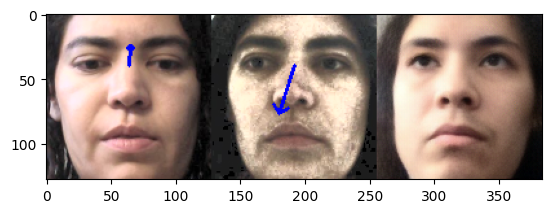

In [86]:
input_dict1 = input_dict
input_dict1["gaze_b"][0][1] += 0.2
input_dict1["gaze_b"][0][0] += 0.2

output_dict, loss_dict = network(input_dict1)
pre = output_dict["image_b_hat"]
pre = (pre[0].permute(1,2,0).detach().cpu().numpy()+1)/2

src = d["image_a"]
dst = d["image_b"]
src = (src[0].permute(1,2,0).cpu().numpy()+1)*255/2
dst = (dst[0].permute(1,2,0).cpu().numpy()+1)*255/2
src = np.ascontiguousarray(src)
dst = np.ascontiguousarray(dst)
src = draw_gaze(src, (64,40), d["gaze_a"][0].cpu().numpy(), length=50)
dst = draw_gaze(dst, (64,40), d["gaze_b"][0].cpu().numpy(), length=50)
src = src/255
dst=dst/255

a = np.hstack([src, dst, pre])
plt.imshow(a)

In [17]:
input_dict["gaze_a"][0][0]

tensor(-0.3023, device='cuda:0')